In [ ]:
zip_path = '/content/drive/My\ Drive/Deep_Learning/daily-min-temperatures.zip'
!cp {zip_path} /content/
!cd /content/
!unzip -q /content/daily-min-temperatures.zip -d /content
!rm /content/daily-min-temperatures.zip

In [ ]:
# From: https://machinelearningmastery.com/exploratory-configuration-multilayer-perceptron-network-time-series-forecasting/
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import numpy as np

In [ ]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

# Data Loading

In [ ]:
dataset = pd.read_csv('/content/daily-min-temperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

dataset.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

## Plot Dataset

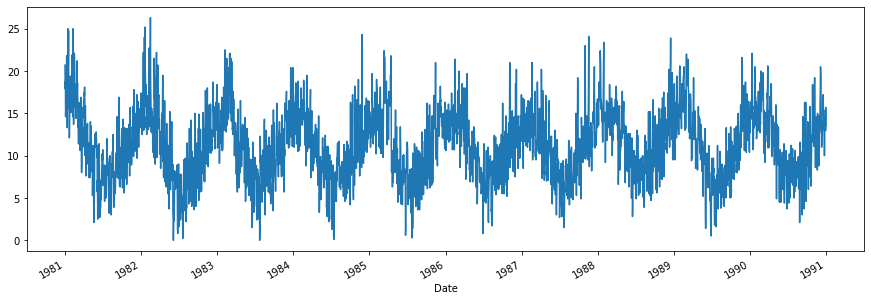

In [ ]:
dataset.plot(figsize=(15,5))
plt.show()

## Processing Time-series Data

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [ ]:
lag = 1

raw_values = dataset.values
diff_values = difference(raw_values, 1)

diff_values

0      -2.8
1       0.9
2      -4.2
3       1.2
4       0.0
       ... 
3644   -0.6
3645   -0.4
3646   -0.1
3647    2.2
3648   -2.7
Length: 3649, dtype: float64

In [ ]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0
0,NaN,-2.8
1,-2.8,0.9
2,0.9,-4.2
3,-4.2,1.2
4,1.2,0.0
...,...,...
3644,1.7,-0.6
3645,-0.6,-0.4
3646,-0.4,-0.1
3647,-0.1,2.2


In [ ]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[-2.8,  0.9],
       [ 0.9, -4.2],
       [-4.2,  1.2],
       ...,
       [-0.4, -0.1],
       [-0.1,  2.2],
       [ 2.2, -2.7]])

In [ ]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) # Range hasil scaling menjadi angka diantara -1 hingga 1
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [ ]:
train_scaled

array([[-0.11607143,  0.21428571],
       [ 0.21428571, -0.24107143],
       [-0.24107143,  0.24107143],
       ...,
       [-0.16071429,  0.375     ],
       [ 0.375     ,  0.125     ],
       [ 0.125     , -0.16071429]])

# Baseline Model

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0656
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0585
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0568
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0564
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0563
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0562
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0561
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0561
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0561
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0561

In [ ]:
loss = model.evaluate(feature_test, label_test, verbose=2)

print("Test loss:", loss)

29/29 - 0s - loss: 0.0560
Test loss: 0.055963292717933655


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

In [ ]:
history_dataframe = pd.DataFrame(history.history)
history_dataframe['epoch'] = history.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
90,0.060679,0.055941,90
95,0.060667,0.055941,95
190,0.060661,0.055942,190
411,0.060653,0.055942,411
507,0.060663,0.055942,507
...,...,...,...
4,0.061079,0.056272,4
3,0.061350,0.056435,3
2,0.062268,0.056826,2
1,0.066284,0.058458,1


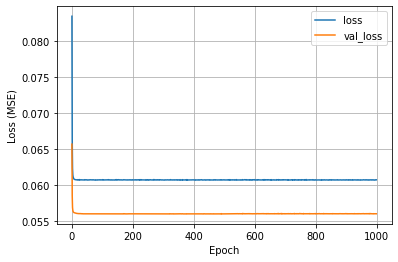

In [ ]:
plot_loss(history) # epoch vs loss graph

# Deeper Model

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0721 - val_loss: 0.0604
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0567
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0560
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560

In [ ]:
deeper_history_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_history_dataframe['epoch'] = deeper_model_history.epoch
deeper_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
300,0.060668,0.055944,300
259,0.060661,0.055944,259
625,0.060662,0.055945,625
624,0.060663,0.055946,624
146,0.060689,0.055946,146
...,...,...,...
539,0.060679,0.056009,539
562,0.060733,0.056023,562
2,0.060942,0.056027,2
1,0.062711,0.056709,1


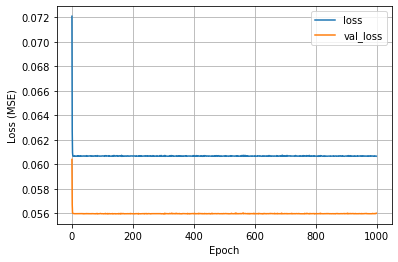

In [ ]:
plot_loss(deeper_model_history) # epoch vs loss graph

# Wider Model

In [ ]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0543
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.0540
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0546
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0539
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0583 - val_loss: 0.0538
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0537
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0583 - val_loss: 0.0541
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0580 - val_loss: 0.0542
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0581 - val_loss: 0.0538
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0537

In [ ]:
wider_history_dataframe = pd.DataFrame(wider_model_history.history)
wider_history_dataframe['epoch'] = wider_model_history.epoch
wider_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
10,0.058146,0.053674,10
13,0.057997,0.053726,13
5,0.058241,0.053727,5
9,0.058159,0.053738,9
39,0.057888,0.053742,39
...,...,...,...
700,0.057537,0.054562,700
822,0.057405,0.054570,822
2,0.058674,0.054593,2
867,0.057439,0.054627,867


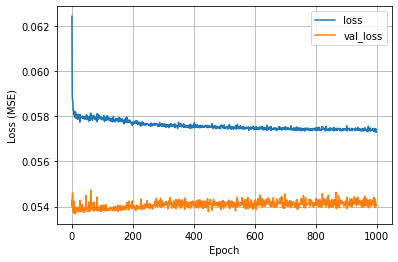

In [ ]:
plot_loss(wider_model_history)

# LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

epoch = 1000
batch_size = 32

# Reshape menjadi (jumlah sample, time steps, jumlah feature)
# Time steps: jumlah lag, gunakan default 1
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 4ms/step - loss: 0.0655 - val_loss: 0.0553
Epoch 2/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0541
Epoch 3/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0542
Epoch 4/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0540
Epoch 5/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0539
Epoch 6/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0539
Epoch 7/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0541
Epoch 8/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0540
Epoch 9/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0541
Epoch 10/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0539

In [ ]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
325,0.057868,0.053779,325
284,0.057941,0.053787,284
324,0.057888,0.053788,324
345,0.057865,0.053793,345
275,0.057971,0.053794,275
...,...,...,...
612,0.057699,0.054539,612
196,0.057994,0.054553,196
703,0.057675,0.054564,703
355,0.057846,0.054737,355


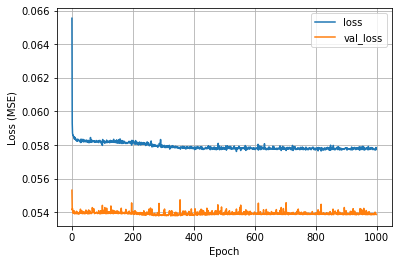

In [ ]:
plot_loss(lstm_model_history)

# Kesimpulan
Arsitektur terbaik untuk dataset daily-min-temperatures adalah wider model, dengan nilai val_loss 0.053674 pada epoch ke-10.